In [228]:
import pandas as pd
import numpy as np
import os

ROOT = 'BatDongSan'
PATH_DATA = os.path.join(ROOT, 'chotot.csv')

In [229]:
import re
from datetime import datetime


class DataPreProcessor():

    def __init__(self, data):
        self.data = data

    def __get_number_from_string(self, x):
        x = x.lower()
        number = int(re.findall(r'\d+', x)[0])
        if 'nhiều hơn' in x:
            return str(number) + '+'
        return number

    def split_number(self, *features):
        for feature in features:
            self.data[feature] = self.data[feature].apply(
                lambda x: self.__get_number_from_string(x) if x is not np.nan else np.nan)

    def drop_column(self, features):
        self.data.drop(features, axis=1, inplace=True)

    def drop_row_nan(self, subset):
        self.data.dropna(subset=subset, inplace=True)

    def convert_timestamp_to_date(self, feature, format='%d/%m/%Y'):
        self.data[feature] = [datetime.fromtimestamp(
            x/1000) for x in df[feature]]
        self.data[feature] = df[feature].dt.strftime(format)

    def check_unique_unit(self, feature):
        unit_uniques = []
        for value in self.data[feature].unique():
            if value is np.nan or isinstance(value, int) or isinstance(value, float):
                continue
            spl = value.split(' ')
            if spl[1] not in unit_uniques:
                unit_uniques.append(spl[1])
        return unit_uniques

    def __remove_unit(self, x, uniques, converters):
        if x is np.nan or isinstance(x, int) or isinstance(x, float):
            return x
        spl = x.split(' ')
        for unit_unique, unit_converter in zip(uniques, converters):
            if spl[1] == unit_unique:
                return float(spl[0].replace(',', '.')) * unit_converter
        return float(spl[0])

    def convert_to_same_unit(self, feature, uniques, converters, add_unit_name=False, unit_name=None):
        if len(uniques) != len(converters):
            print("[ERROR] - Length uniques and converters are not the same")
            return

        self.data[feature] = self.data[feature].apply(lambda x: self.__remove_unit(x, uniques, converters))
        if add_unit_name:
            if unit_name is None:
                print("[ERROR] - Unit name can not none")
            else:
                self.data.rename(columns={feature: f'{feature} ({unit_name})'}, inplace=True)

    def convert_unit(self, feature, convert_rate, add_unit_name=False, unit_name=None):
        self.data[feature] = self.data[feature].apply(
            lambda x: x/convert_rate if x is not np.nan else np.nan)
        
        if add_unit_name:
            if unit_name is None:
                print("[ERROR] - Unit name can not none")
            else:
                self.data.rename(columns={feature: f'{feature} ({unit_name})'}, inplace=True)

    def merge_column(self, *features):
        return

    def save_as_csv(self, file_name):
        self.data.to_csv(file_name, index=False)


In [230]:
df = pd.read_csv(PATH_DATA)

C:\Users\dinhc\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3172: DtypeWarning: Columns (7,10,14,16,19,24,26) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [231]:
[i for i in df.columns]

['id',
 'list_time',
 'type_real_estate',
 'ward',
 'area',
 'region',
 'address',
 'property_status',
 'price_m2',
 'direction',
 'balconydirection',
 'property_legal_document',
 'size',
 'floornumber',
 'apartment_type',
 'furnishing_sell',
 'apartment_feature',
 'rooms',
 'toilets',
 'floors',
 'house_type',
 'living_size',
 'width',
 'length',
 'land_type',
 'property_road_condition',
 'land_feature',
 'property_back_condition',
 'price']

In [232]:
p = DataPreProcessor(df)

# Drop thuộc tính id và price_m2
p.drop_column(['id', 'price_m2'])

# Xóa các dòng bị missing của hai thuộc tính là price và list_time
p.drop_row_nan(['price'])
p.drop_row_nan(['list_time'])

# Chuyển thời gian timestamp thành date
p.convert_timestamp_to_date('list_time')

# Tách lấy số của thuộc tính rooms và toilets
p.split_number('rooms', 'toilets')

In [233]:
# Kiểm tra đơn vị của thuộc tính size
unit_unique = p.check_unique_unit('size')
print(unit_unique)
# Đổi các đơn vị của thuộc tính size về cùng một đơn vị theo một tỷ lệ
unit_convert = [1, 1, 10000]
p.convert_to_same_unit('size', unit_unique, unit_convert, add_unit_name=True, unit_name='m2')

['m²', 'm2', 'hecta']


In [234]:
# Kiểm tra đơn vị của thuộc tính living_size
unit_unique = p.check_unique_unit('living_size')
print(unit_unique)
# Đổi các đơn vị của thuộc tính living_size về cùng một đơn vị theo một tỷ lệ
unit_convert = [1]
p.convert_to_same_unit('living_size', unit_unique, unit_convert, add_unit_name=True, unit_name='m2')

['m²']


In [235]:
# Kiểm tra đơn vị của thuộc tính width
unit_unique = p.check_unique_unit('width')
print(unit_unique)
# Đổi các đơn vị của thuộc tính width về cùng một đơn vị theo một tỷ lệ
unit_convert = [1]
p.convert_to_same_unit('width', unit_unique, unit_convert, add_unit_name=True, unit_name='m')

['m']


In [236]:
# Kiểm tra đơn vị của thuộc tính length
unit_unique = p.check_unique_unit('length')
print(unit_unique)
# Đổi các đơn vị của thuộc tính length về cùng một đơn vị theo một tỷ lệ
unit_convert = [1]
p.convert_to_same_unit('length', unit_unique, unit_convert, add_unit_name=True, unit_name='m')

['m']


In [237]:
# Chuyển đổi giá của thuộc tính size từ đơn vị đồng về triệu
p.convert_unit('price', 1000000, add_unit_name=True, unit_name='million')

In [238]:
# Xuất ra file csv
p.save_as_csv('chotot_cleaned.csv')

In [239]:
p.data.describe()

,size (m2),floornumber,living_size (m2),width (m),length (m),price (million)
count,9.525700e+04,3876.000000,42737.000000,73725.000000,72877.000000,9.540900e+04
mean,3.093060e+04,12.199690,166.610159,21.722333,41.086344,1.826762e+07
std,4.411510e+06,12.160109,1126.917752,1207.894713,898.128423,5.640653e+09
min,1.000000e+00,1.000000,1.000000,1.000000,1.000000,3.700000e-01
25%,5.079000e+01,6.000000,64.000000,4.000000,12.000000,1.773000e+03
50%,7.200000e+01,10.000000,100.000000,5.000000,16.000000,3.450000e+03
75%,1.120000e+02,17.000000,180.000000,6.000000,22.000000,6.100000e+03
max,9.000000e+08,456.000000,123456.000000,315375.000000,135000.000000,1.742304e+12


In [240]:
for column in p.data.columns:
    print('Feature:', column)
    print(p.data[column].unique())
    print('\n')

Feature: list_time
['05/11/2021' '04/11/2021' '03/11/2021' '02/11/2021' '01/11/2021'
 '31/10/2021' '30/10/2021' '29/10/2021' '28/10/2021' '27/10/2021'
 '26/10/2021' '25/10/2021' '24/10/2021' '23/10/2021' '22/10/2021'
 '21/10/2021' '20/10/2021' '19/10/2021' '18/10/2021' '17/10/2021'
 '16/10/2021' '15/10/2021' '14/10/2021' '13/10/2021' '12/10/2021'
 '11/10/2021' '10/10/2021' '09/10/2021' '08/10/2021' '07/10/2021'
 '06/10/2021' '05/10/2021' '04/10/2021' '03/10/2021' '01/10/2021'
 '30/09/2021' '29/09/2021' '28/09/2021' '27/09/2021' '26/09/2021'
 '25/09/2021' '24/09/2021' '23/09/2021' '22/09/2021' '21/09/2021'
 '18/09/2021' '17/09/2021' '16/09/2021' '15/09/2021' '13/09/2021'
 '10/09/2021' '09/09/2021' '08/09/2021' '07/09/2021' '06/09/2021'
 '16/08/2021' '02/10/2021' '20/09/2021' '19/09/2021' '14/09/2021'
 '12/09/2021' '11/09/2021' '13/08/2021' '31/07/2021' '24/05/2021'
 '11/05/2021' '13/04/2021' '11/04/2021' '07/04/2021' '28/03/2021'
 '26/03/2021' '27/05/2020' '14/08/2021' '03/09/2021' '28/

In [241]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualizing_missing_data(df):
    missing_values = df.isnull().sum() / len(df)
    # missing_values = missing_values[missing_values > 0]
    # missing_values.sort_values(inplace=True)
    missing_values = missing_values.to_frame()
    missing_values.columns = ['ratio']
    missing_values.index.names = ['feature']
    missing_values['feature'] = missing_values.index
    print(missing_values)
    plt.figure(figsize=(10, 10))
    sns.set(style="whitegrid", color_codes=False)
    sns.barplot(x = 'feature', y = 'ratio', data=missing_values)
    plt.xticks(rotation = 90)
    plt.show()

                            ratio                  feature
feature                                                   
list_time                0.000000                list_time
type_real_estate         0.000000         type_real_estate
ward                     0.000241                     ward
area                     0.000021                     area
region                   0.000000                   region
address                  0.000293                  address
property_status          0.863346          property_status
direction                0.661458                direction
balconydirection         0.954878         balconydirection
property_legal_document  0.140050  property_legal_document
size (m2)                0.001593                size (m2)
floornumber              0.959375              floornumber
apartment_type           0.863336           apartment_type
furnishing_sell          0.725749          furnishing_sell
apartment_feature        0.969804        apartment_featu

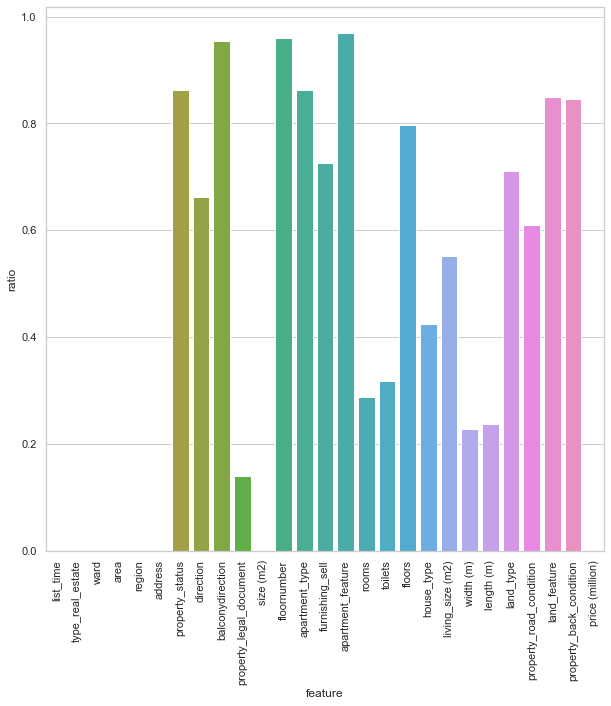

In [242]:
visualizing_missing_data(df)